# Gradient Descent 

In [1]:
import logging 
import numpy as np 
import pandas as pd

import algo_ecg.data
import algo_ecg.preprocessing
from algo_ecg.feature_transformer import \
calculate_hrv_based_on_peak_intervals3, \
FindPeaksCustomTransformer, select_cols

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

import seaborn as sns

Sigmoid function 
$$f(x) = \frac{1}{1 + e^{-(x)}}$$

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Cost function 
$$J(\theta) = -\frac{1}{m}\sum[y^{(i)}log(h\theta(x^{(i)})) + (1-y^{(i)})log(1-h\theta(x^{(i)}))]$$

Partial derivative
$$\frac{\partial}{\partial\theta}J(\theta) = \frac{1}{m}\sum(h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}$$

In [3]:
def cost_function(X, y, theta):
    m = len(y)
    h = sigmoid(np.dot(X, theta))
    cost = -(1 / m) * (np.dot(y, np.log(h)) + np.dot(1 - y, np.log(1 - h)))
    return cost

Parameter update via gradient descent: 
$$\theta_{j} := \theta_{j} - \alpha (\frac{1}{m} \sum \limits_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)})$$

In [4]:
def gradient_descent(X, y, theta, alpha, num_iterations):
    m = len(y)
    theta_history = []
    cost_history = []
    for _ in range(num_iterations):
        h = sigmoid(np.dot(X, theta))
        error = h - y
        gradient = (1 / m) * np.dot(X.T, error)
        theta -= alpha * gradient
        cost = cost_function(X, y, theta)
        theta_history.append(theta.copy())
        cost_history.append(cost)
#        print(f'Iteration {_ + 1}/{num_iterations}, Cost: {cost}')
#        print(f'Iteration {_ + 1}/{num_iterations}, theta: {theta}')
    return theta, theta_history, cost_history

def predict(X, theta):
    probabilities = sigmoid(np.dot(X, theta))
    predictions = (probabilities >= 0.5).astype(int)
    return predictions

# Load data and run

In [5]:
X_in, y, pids = algo_ecg.data.import_physionet_data('/Users/jessie/data/PhysioNet_CinC', num_files_to_read=1000)
X, pids = algo_ecg.preprocessing.preprocess_pid(X_in, pids)
slice_length = len(X[0])
X = np.concatenate(X).reshape(-1, slice_length, 1)
X = pd.DataFrame.from_records(X)

In [6]:
pipe = Pipeline(steps=[
    ('peaks', FindPeaksCustomTransformer (axis=1)), 
    ('feature_select_manual',FunctionTransformer(select_cols, kw_args={"col_names": ['RMSSD_ms','pNN50']})),
    ('standardscaler', StandardScaler())
])


In [7]:
X_df = pipe.fit_transform(X)

In [8]:
X_df2 = pd.DataFrame.from_records(X_df)

In [9]:
X_df2.head(2)

,0,1
0,-0.865775,-0.829206
1,1.869359,0.814616


In [10]:
X_df

array([[-0.86577515, -0.82920565],
       [ 1.86935931,  0.81461551],
       [-0.99278042, -0.82920565],
       ...,
       [ 0.76672786,  1.0688941 ],
       [-0.39416386, -0.76149143],
       [-0.63272357, -0.48829956]])

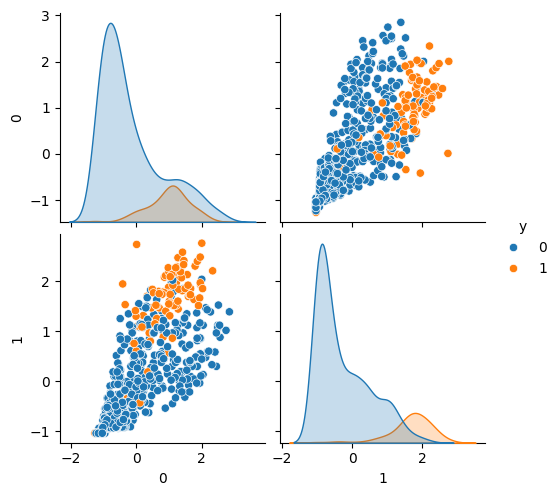

In [11]:
X_df2['y'] = y
sns.pairplot(X_df2, hue = "y")

In [12]:
x_0 = np.ones(X_df.shape[0]).reshape(X_df.shape[0],1)
#x_0

In [13]:
X2 = np.concatenate((x_0, X_df), axis=1)
X2.shape

(690, 3)

In [21]:
theta_initial = np.ones(X2.shape[1])

In [29]:
print (X2.shape, theta_initial.shape)
X2[0:3,:]

(690, 3) (3,)


array([[ 1.        , -0.86577515, -0.82920565],
       [ 1.        ,  1.86935931,  0.81461551],
       [ 1.        , -0.99278042, -0.82920565]])

In [37]:
%%time
theta_initial = np.zeros(X2.shape[1])
num_iterations=1000
alpha=0.1
#theta, J_history, theta0_history, \
#theta1_history, theta2_history = gradient_descent(X2,y,initial_theta2,
#                                                  alpha,num_iterations)

theta, theta_history, J_history = \
gradient_descent(X2, y, theta_initial, alpha, num_iterations)




CPU times: user 65.8 ms, sys: 2.74 ms, total: 68.6 ms
Wall time: 66 ms


In [38]:
theta0_history = [row[0] for row in theta_history]
theta1_history = [row[1] for row in theta_history]
theta2_history = [row[2] for row in theta_history]


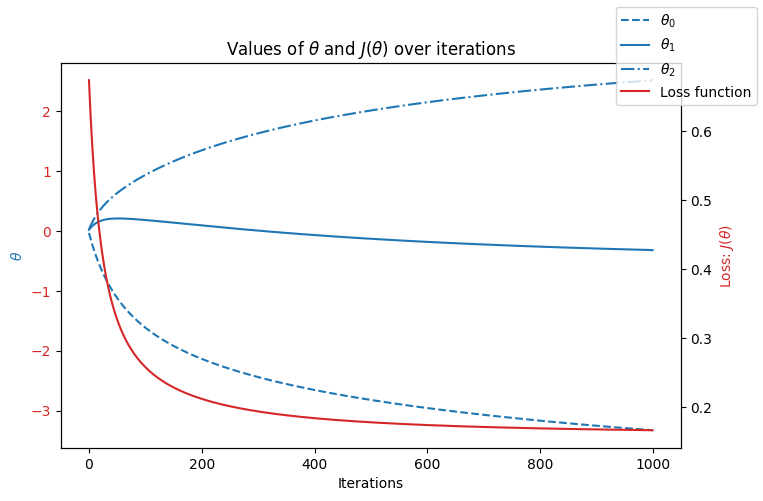

In [39]:
fig, ax1 = plt.subplots(figsize=(8,5))

# plot thetas over time
color='tab:blue'
ax1.plot(theta0_history, label='$\\theta_{0}$', linestyle='--', color=color)
ax1.plot(theta1_history, label='$\\theta_{1}$', linestyle='-', color=color)
ax1.plot(theta2_history, label='$\\theta_{2}$', linestyle='-.', color=color)
# ax1.legend()
ax1.set_xlabel('Iterations'); ax1.set_ylabel('$\\theta$', color=color);
ax1.tick_params(axis='y', labelcolor=color)

# plot loss function over time
color='tab:red'
ax2 = ax1.twinx()
ax2.plot(J_history, label='Loss function', color=color)
ax2.set_title('Values of $\\theta$ and $J(\\theta)$ over iterations')
ax2.set_ylabel('Loss: $J(\\theta)$', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# ax2.legend();
fig.legend();

# Decision boundary

In [27]:
from sklearn.linear_model import LogisticRegression
X = X_df
clf = LogisticRegression(random_state=0).fit(X, y)

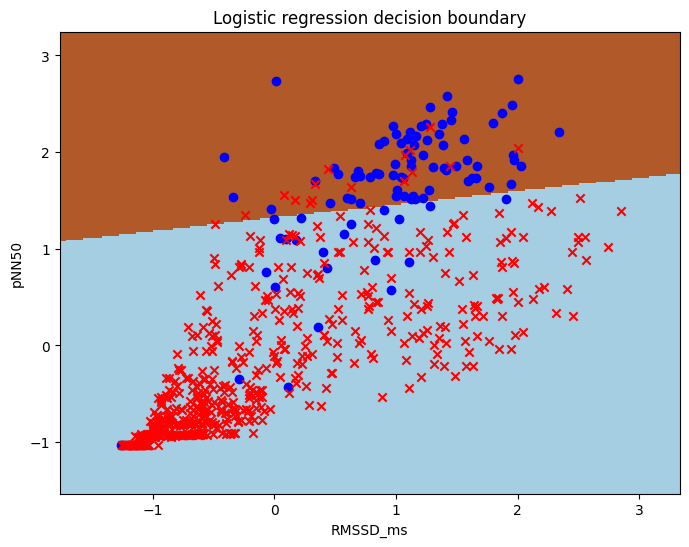

In [28]:
pos = np.where(y == 1)
neg = np.where(y == 0)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(8, 6))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
# plt.scatter(X[:, 0], X[:, 1], edgecolors='k', cmap=plt.cm.Paired)
plt.scatter(X[pos, 0], X[pos, 1], marker='o', c='b')
plt.scatter(X[neg, 0], X[neg, 1], marker='x', c='r')
plt.xlabel('RMSSD_ms')
plt.ylabel('pNN50')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Logistic regression decision boundary');